# Python

**Напишите на Python генератор первых *n* чисел Фибоначчи**

In [1]:
def fibonacci_generator(n):
    for i in range(n):
        if i == 0:
            a, b = 0, 1
        else:
            b, a = b + a, b

        yield b

In [2]:
n = 10

for num in fibonacci_generator(n):
    print(num, end='\t')

1	1	2	3	5	8	13	21	34	55	

# SQL

In [ ]:
# Проверить корректность решения можно на http://sqlfiddle.com

create table department (id int, name varchar(30));

insert into department (id, name) values (1, 'Финансы');
insert into department (id, name) values (2, 'Риски');
insert into department (id, name) values (3, 'Розница');
insert into department (id, name) values (4, 'Безопасность');
insert into department (id, name) values (1000, 'ДКК');

create table personal (id int, id_head int, id_dep int, name varchar(30), sal int);

insert into personal (id, id_head, id_dep, name, sal) values (1, 1, 2, 'Бегинс', 45000);
insert into personal (id, id_head, id_dep, name, sal) values (2, 1, 2, 'Поттер', 80000);
insert into personal (id, id_head, id_dep, name, sal) values (3, 2, 2, 'Чапаев', 100000);
insert into personal (id, id_head, id_dep, name, sal) values (4, 4, 4, 'Шилов', 65000);
insert into personal (id, id_head, id_dep, name, sal) values (1000, 5, 3, 'Наумов', 64500);

**а) Вывести отдел с наибольшим числом сотрудников**

In [ ]:
select name from department join (
  select id_dep, count(*) as count from personal group by id_dep order by count desc limit 1
) as t on department.id = t.id_dep

**б) Вывести список сотрудников, получающих заработную плату выше, чем у руководителя**

In [ ]:
select id, personal.id_head, id_dep, name, personal.sal from personal left join (
  select id_head, sal from personal where personal.id = personal.id_head
) as t on personal.id_head = t.id_head where personal.sal > t.sal

# Определение отрасли компании

## Загрузка и подготовка данных

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import cm as cmap
import seaborn as sns
from scipy import stats
from sklearn import model_selection, preprocessing, metrics
from sklearn import neighbors, naive_bayes, linear_model, ensemble, svm, neural_network, gaussian_process
from lightgbm import LGBMClassifier
import joblib

In [25]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.size'] = 10

In [43]:
df_pays = pd.read_csv('pays.csv')
df_pays.head()

,hash_inn_kt,hash_inn_dt,week,count,sum
0,0,0,1,4,38399.6
1,0,0,5,2,399.6
2,0,0,7,2,79.6
3,0,0,9,2,239.6
4,0,0,12,2,79.6


In [44]:
df_pays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430150 entries, 0 to 5430149
Data columns (total 5 columns):
hash_inn_kt    int64
hash_inn_dt    int64
week           int64
count          int64
sum            float64
dtypes: float64(1), int64(4)
memory usage: 207.1 MB


In [45]:
df_inn = pd.read_csv('inn_info_public.csv')
df_inn.head()

,hash_inn,okved2,region,is_public
0,61058,34,86,True
1,8311,18,86,True
2,130273,-1,86,False
3,64081,43,86,True
4,218005,12,86,True


In [46]:
df_inn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240069 entries, 0 to 240068
Data columns (total 4 columns):
hash_inn     240069 non-null int64
okved2       240069 non-null int64
region       240069 non-null int64
is_public    240069 non-null bool
dtypes: bool(1), int64(3)
memory usage: 5.7 MB


In [47]:
all_uniq_hash_prediction = df_inn[df_inn.okved2 == -1].hash_inn.unique()

In [48]:
all_uniq_hash_prediction.shape

(78654,)

**Количество уникальных ИНН, для которых нужно сделать предсказание, составляет 78 с половиной тысяч**

### Таблица для анализа, обучающая выборка

In [57]:
# в качестве столбца для соединения таблиц возьмем обезличенный ИНН отправителя в таблице pays
# скорее всего именно он соответствует полю ИНН в таблице inn_info
df = pd.merge(left=df_pays, right=df_inn, left_on='hash_inn_kt', right_on='hash_inn', how='inner')
df.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region,is_public
0,0,0,1,4,38399.6,0,-1,84,False
1,0,0,5,2,399.6,0,-1,84,False
2,0,0,7,2,79.6,0,-1,84,False
3,0,0,9,2,239.6,0,-1,84,False
4,0,0,12,2,79.6,0,-1,84,False


In [58]:
df.shape

(5430150, 9)

**В столбце `sum` встречается 1125 пропущенных значений. Заполним их средним значением по столбцу**

In [59]:
df[df['sum'].isna()].shape

(1125, 9)

In [60]:
df['sum'].fillna(df['sum'].mean(), inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5430150 entries, 0 to 5430149
Data columns (total 9 columns):
hash_inn_kt    int64
hash_inn_dt    int64
week           int64
count          int64
sum            float64
hash_inn       int64
okved2         int64
region         int64
is_public      bool
dtypes: bool(1), float64(1), int64(7)
memory usage: 378.0 MB


In [62]:
df_train = df[df.okved2 != -1]
df_train.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region,is_public
85,1,31310,5,2,12.4,1,62,26,True
86,1,31310,6,2,12.4,1,62,26,True
87,1,31310,8,2,12.4,1,62,26,True
88,1,31310,9,2,25.2,1,62,26,True
89,1,31310,11,2,25.2,1,62,26,True


In [63]:
df_train.shape

(3718501, 9)

In [64]:
df_train.is_public.value_counts()

True    3718501
Name: is_public, dtype: int64

**Все значения признака `is_public` равны True. Исключаем его из таблицы**

In [65]:
df_train = df_train.drop('is_public', axis=1)

**Посмотрим на распределение классов**

In [99]:
# количество классов
df_train.okved2.value_counts().shape

(80,)

Text(0, 0.5, 'Количество')

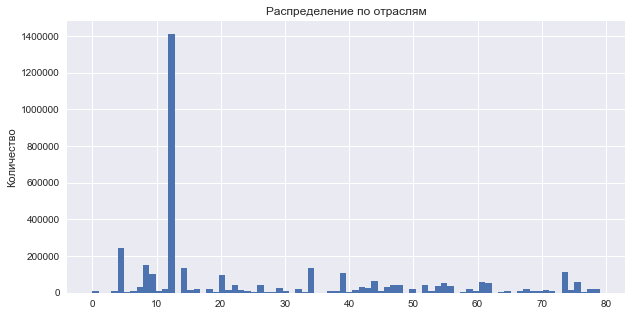

In [101]:
df_train.okved2.plot(kind='hist', bins=80)
plt.title('Распределение по отраслям')
plt.ylabel('Количество')

In [53]:
df_train.okved2.value_counts().head()

12    1410735
4      246685
8      150451
14     132930
34     132862
Name: okved2, dtype: int64

In [54]:
df_train.okved2.value_counts().tail()

51    516
49    319
1     289
73    202
66     31
Name: okved2, dtype: int64

In [55]:
np.median(df_train.okved2.value_counts().values)

13388.0

**Видим, что 12 и 4 класса гораздо больше остальных классов. В то же время классы 66 и 73 практически отсутствуют. Медиана количества наблюдений в классах составляет 13 тысяч** 

**Попробуем применить undersampling и oversampling, чтобы сбалансировать количество наблюдений в каждом классе для обучения моделей - там где количество наблюдений больше 13 тысяч более чем в 4 раза будем уменьшать количество до примерно 52 тысяч, там где количество наблюдений гораздо меньше 13 тысяч, будем увеличивать количество до примерно 3 тысяч**

*Стоит отметить, что использование иного подхода к oversampling, такого как, например, SMOTE, неприемлемо, поскольку он будет интерпретировать категориальные признаки как числовые и это может привести к непредсказуемым результатам при обучении и дальнейшем предсказании номера отрасли*

#### under- и oversampling

In [24]:
df_ = [] 

for i, j in df_train.okved2.value_counts().items():

    if j > 52000:
        n = np.random.randint(51500, 52500)
        df_.append(df_train[df_train.okved2 == i].sample(n))
        
    elif j < 3000:
        n = np.random.randint(3000, 3300)
        df_.append(df_train[df_train.okved2 == i].sample(n, replace=True))

    else:
        df_.append(df_train[df_train.okved2 == i])

In [25]:
df_train = pd.concat(df_, ignore_index=True)

Text(0, 0.5, 'Количество')

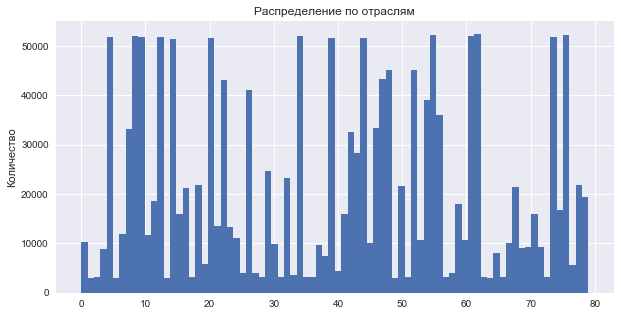

In [66]:
df_train.okved2.plot(kind='hist', bins=80)
plt.title('Распределение по отраслям')
plt.ylabel('Количество')

**Полученное распределение кажется более сбалансированным. Будем использовать его для обучения моделей**

In [60]:
df_train.shape

(1690866, 8)

In [28]:
df_train.to_csv('training_set.csv', index=False)

**Посмотрим на распределение по регионам в сформированной обучающей выборке**

In [80]:
# количество регионов
df_train.region.value_counts().shape

(87,)

Text(0, 0.5, 'Количество')

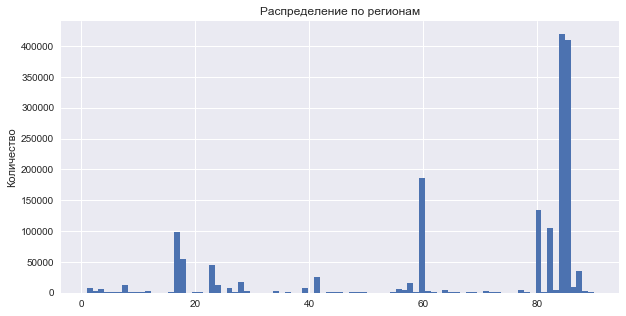

In [81]:
df_train.region.plot(kind='hist', bins=87)
plt.title('Распределение по регионам')
plt.ylabel('Количество')

**Отметим, что в основном все наблюдения из 84 и 85 регионов - наверное это Москва и Московская область**

**Тем не менее в топ по количеству и сумме платежей в неделю находятся 59 и 67 регионы:**

In [106]:
df_train.groupby('region')[['count']].median().sort_values(by='count', ascending=False).head()

,count
region,
67,4
59,3
42,3
26,3
51,3


In [104]:
df_train.groupby('region')[['sum']].median().sort_values(by='sum', ascending=False).head()

,sum
region,
59,1901.600
67,1458.160
52,983.696
33,239.600
14,193.490


**Аналогичным образом оценим отрасли по количеству и сумме платежей в неделю:**

In [108]:
df_train.groupby('okved2')[['count']].median().sort_values(by='count', ascending=False).head()

,count
okved2,
66,3
0,2
59,2
57,2
56,2


In [109]:
df_train.groupby('okved2')[['sum']].median().sort_values(by='sum', ascending=False).head()

,sum
okved2,
57,197.252
2,149.600
66,127.600
31,119.600
17,95.604


**Видим, что 57 и 66 отрасли являются самыми платежеспособными (или самыми платежеобязанными)**

In [112]:
df_train.groupby(['okved2','region'])[['sum']].median().sort_values(by='sum', ascending=False).head()

,,sum
okved2,region,
74,4,240025.254
58,57,20003.600
8,63,16370.022
2,39,9999.600
74,16,8439.238


**Также видим, что больше всего в среднем платит 4 регион по 74 отрасли - это, вероятно, добывающая или пищевая промышленность**

**Наконец укажем, что корреляция между количеством платежей и суммой платежей в неделю является значимой, но субъективно не очень высокой:**

In [115]:
stats.spearmanr(df_train['count'], df_train['sum'])

SpearmanrResult(correlation=0.3950407628767458, pvalue=0.0)

**В заключение посмотрим на количество категорий ИНН отправителя и получателя**

In [20]:
# ИНН отправителя
df_train.hash_inn_kt.unique().shape

(76604,)

In [31]:
df_train.hash_inn_kt.unique().shape[0] / df_train.shape[0]

0.04530459539667839

In [32]:
# ИНН получателя
df_train.hash_inn_dt.unique().shape

(126920,)

In [33]:
df_train.hash_inn_dt.unique().shape[0] / df_train.shape[0]

0.07506212792734611

**Количество категорий ИНН отправителя и получателя составляет примерно 5% и 8% соответственно от общего размера сформированной тестовой выборки. Не будем исключать их из тестовой выборки - возможно они положительно повлияют на качество классификации**

#### Альтернативная обучающая выборка

**Здесь следующая идея: давайте группировать по ИНН и для каждого ИНН считать среднюю, максимальную и минимальную сумма платежей, среднее, максимальное и минимальное количество платежей, моду недели, региона и ИНН получателя и далее составлять из этого обучающую выборку**

In [85]:
df_train_alt = df[df.okved2 != -1]
df_train_alt = df_train_alt.drop('is_public', axis=1)
df_train_alt = df_train_alt.drop('hash_inn_kt', axis=1)
df_train_alt.head()

,hash_inn_dt,week,count,sum,hash_inn,okved2,region
85,31310,5,2,12.4,1,62,26
86,31310,6,2,12.4,1,62,26
87,31310,8,2,12.4,1,62,26
88,31310,9,2,25.2,1,62,26
89,31310,11,2,25.2,1,62,26


In [88]:
data = []

for inn, group in df_train_alt.groupby('hash_inn'):
    
    data.append((
        inn,
        group['sum'].max(),
        group['sum'].min(),
        group['sum'].mean(),
        group['count'].max(),
        group['count'].min(),
        group['count'].mean(),
        group['hash_inn_dt'].value_counts().index[0],
        group['week'].value_counts().index[0],
        group['region'].value_counts().index[0],
        group['okved2'].value_counts().index[0]
    ))

In [89]:
df_train_alt = pd.DataFrame(data, columns=['inn', 'max_sum', 'min_sum', 'mean_sum',
                                           'max_count', 'min_count', 'mean_count',
                                           'inn_dt', 'week', 'region', 'okved2'])

In [90]:
df_train_alt.head()

,inn,max_sum,min_sum,mean_sum,max_count,min_count,mean_count,inn_dt,week,region,okved2
0,1,25.200,12.400,19.714286,2,2,2.000000,31310,15,26,62
1,3,13.948,13.948,13.948000,1,1,1.000000,17473,15,60,29
2,5,31.936,0.556,13.496364,6,1,2.090909,230506,22,85,14
3,7,3244.836,8.420,882.672842,15,1,3.684211,214170,8,18,12
4,8,643.880,6.128,181.044000,2,2,2.000000,238660,19,60,11


In [91]:
df_train_alt.to_csv('training_set_alt.csv', index=False)

### Таблица для прогнозирования отрасли

In [23]:
df_prediction = df[df.okved2 == -1]
df_prediction.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region,is_public
0,0,0,1,4,38399.6,0,-1,84,False
1,0,0,5,2,399.6,0,-1,84,False
2,0,0,7,2,79.6,0,-1,84,False
3,0,0,9,2,239.6,0,-1,84,False
4,0,0,12,2,79.6,0,-1,84,False


In [24]:
df_prediction.shape

(1711649, 9)

In [80]:
df_prediction[df_prediction.okved2 == -1].hash_inn.unique().shape

(49966,)

**К сожалению, после пересечения с таблицей pays осталось только около 50 тысяч уникальных ИНН из 78 с половиной тысяч, по которым доступна информация. По остальным ИНН предсказание сделать не получится**

In [25]:
df_prediction.is_public.value_counts()

False    1711649
Name: is_public, dtype: int64

In [26]:
df_prediction = df_prediction.drop('is_public', axis=1)

In [27]:
df_prediction.to_csv('prediction_set.csv', index=False)

# Обучение моделей

In [2]:
df_train = pd.read_csv('training_set.csv')
df_train.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,hash_inn,okved2,region
0,129670,192730,9,2,5.120,129670,12,23
1,98098,113887,4,2,313.752,98098,12,86
2,71166,243907,17,3,5.760,71166,12,28
3,68412,216590,3,2,51.880,68412,12,26
4,218472,25060,10,1,27.160,218472,12,1


In [3]:
X = df_train.drop(['hash_inn', 'okved2'], axis=1)
y = df_train.okved2.values

**Преобразуем признак `sum` в диапазон от 0 до 1**

**Преобразуем признаки в `int32` и `float32`, чтобы уменьшить потребление памяти**

In [4]:
X['sum'] = (X['sum'] - X['sum'].min()) / (X['sum'].max() - X['sum'].min())

In [5]:
for c in X.columns:
    if c == 'sum':
        X[c] = X[c].astype(np.float32)
    else:
        X[c] = X[c].astype(np.int32)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1690866 entries, 0 to 1690865
Data columns (total 6 columns):
hash_inn_kt    int32
hash_inn_dt    int32
week           int32
count          int32
sum            float32
region         int32
dtypes: float32(1), int32(5)
memory usage: 38.7 MB


In [7]:
X.describe()

,hash_inn_kt,hash_inn_dt,week,count,sum,region
count,1.690866e+06,1.690866e+06,1.690866e+06,1.690866e+06,1.690866e+06,1.690866e+06
mean,1.277280e+05,1.301890e+05,1.163021e+01,2.858393e+00,1.365578e-04,6.836800e+01
std,7.568960e+04,7.556123e+04,6.332667e+00,5.544837e+00,2.943685e-03,2.498680e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,6.024100e+04,6.425500e+04,6.000000e+00,1.000000e+00,7.563534e-07,6.000000e+01
50%,1.261320e+05,1.292625e+05,1.200000e+01,2.000000e+00,3.408632e-06,8.400000e+01
75%,1.939790e+05,1.959580e+05,1.700000e+01,3.000000e+00,1.869706e-05,8.500000e+01
max,2.605100e+05,2.605140e+05,2.300000e+01,2.272000e+03,1.000000e+00,9.000000e+01


## Поиск baseline

In [16]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
models = ['KNeighbors', 'Bayes', 'LogisticRegression', 'RandomForest', 'AdaBoost', 'SVC', 'MLP', 'Gaussian', 'GBM']
scores = []

for m in models:

    if m == 'KNeighbors':
        model = neighbors.KNeighborsClassifier()
    elif m == 'Bayes':
        model = naive_bayes.ComplementNB()
    elif m == 'LogisticRegression':
        model = linear_model.LogisticRegression(random_state=42, multi_class='multinomial', solver='newton-cg')
    elif m == 'RandomForest':
        model = ensemble.RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150)
    elif m == 'AdaBoost':
        model = ensemble.AdaBoostClassifier(random_state=42, n_estimators=150)
    elif m == 'SVC':
        model = svm.SVC(random_state=42, class_weight='balanced', gamma='auto')
    elif m == 'MLP':
        model = neural_network.MLPClassifier(random_state=42)
    elif m == 'Gaussian':
        model = gaussian_process.GaussianProcessClassifier(random_state=42)
    elif m == 'GBM':
        model = LGBMClassifier(random_state=42, objective='multiclass')
        
    score = model_selection.cross_val_score(model, X, y, scoring='accuracy', cv=skf, n_jobs=1, verbose=13).mean()
    scores.append(score)
    print(m, score)
    
# KNeighbors 0.6352626423154838
# Bayes 0.03574327360381763
# LogisticRegression 0.053765947241550455
# RandomForest ?
# AdaBoost 0.10477180166477877
# SVC ?
# MLP 0.030832718005585208
# Gaussian ?
# GBM 0.49358907991174755

In [ ]:
pd.DataFrame({'model': models, 'score': scores})

**К сожалению не все модели удалось оценить. Фактически это связано с большим объемом выборки и ограниченными вычислительными и временными ресурсами. Тем не менее, можно увидеть что алгоритм ближайших соседей превосходит все остальные модели, в том числе и градиентный бустинг - будем считать его лучшей baseline моделью**

## Подбор гиперпараметров лучшей baseline модели

In [17]:
clf = neighbors.KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5, 8, 11, 13], 'weights': ['distance'], 
              'algorithm': ['auto', 'ball_tree', 'kd_tree'],
              'p': [1, 2, 3, 4], 'leaf_size': [20, 25, 30, 35, 40]}

gs = model_selection.RandomizedSearchCV(clf, param_grid, cv=skf, scoring='accuracy', 
                                        random_state=42, n_iter=13, verbose=13, n_jobs=2)

gs.fit(X, y)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:   40.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   53.2s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:  1.5min
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.2min
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:  2.2min
[Parallel(

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=13, n_jobs=2,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree'],
                                        'leaf_size': [20, 25, 30, 35, 40],
                                        'n_neighbors': [3, 5, 8, 11, 13],
                                        'p': [1, 2, 3, 4],
                                        

In [81]:
print(gs.best_score_)
print(gs.best_estimator_)

0.8092983122258062
KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=1,
                     weights='distance')


In [83]:
joblib.dump(gs, 'gs_KNeighborsClassifier.joblib')

['gs_KNeighborsClassifier.joblib']

In [22]:
y_predicted = gs.best_estimator_.predict(X)

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5, 56.5, 58.5, 60.5, 62.5, 64.5,
        66.5, 68.5, 70.5, 72.5, 74.5, 76.5, 78.5]),
 <a list of 40 Text xticklabel objects>)

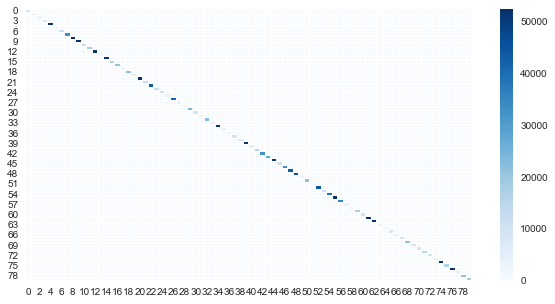

In [32]:
cm = metrics.confusion_matrix(y, y_predicted)
sns.heatmap(cm, annot=False, linewidths=.1, cmap='Blues')
plt.xticks(rotation=0)

**Похоже, что `KNeighborsClassifier` предсказывает очень хорошо на обучающей выборке. Вполне возможно, что он переобучился**

[learning_curve] Training set sizes: [  56361  175345  294329  413313  532298  651282  770267  889251 1008235
 1127220]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of  30 | elapsed:    9.2s remaining:  4.4min
[Parallel(n_jobs=2)]: Done   4 out of  30 | elapsed:   42.4s remaining:  4.6min
[Parallel(n_jobs=2)]: Done   7 out of  30 | elapsed:  1.5min remaining:  4.8min
[Parallel(n_jobs=2)]: Done  10 out of  30 | elapsed:  2.2min remaining:  4.4min
[Parallel(n_jobs=2)]: Done  13 out of  30 | elapsed:  2.8min remaining:  3.6min
[Parallel(n_jobs=2)]: Done  16 out of  30 | elapsed:  3.5min remaining:  3.1min
[Parallel(n_jobs=2)]: Done  19 out of  30 | elapsed:  4.4min remaining:  2.5min
[Parallel(n_jobs=2)]: Done  22 out of  30 | elapsed:  4.9min remaining:  1.8min
[Parallel(n_jobs=2)]: Done  25 out of  30 | elapsed:  5.5min remaining:  1.1min
[Parallel(n_jobs=2)]: Done  28 out of  30 | elapsed:  6.4min remaining:   27.5s
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  7.1min finished


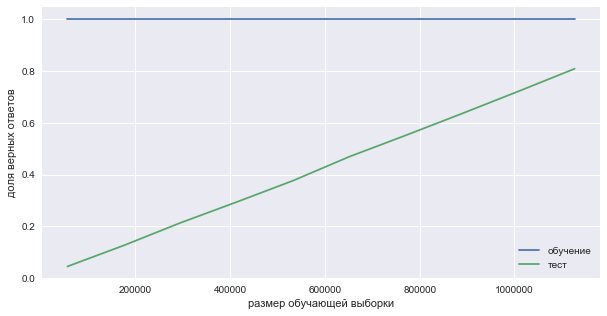

In [36]:
def plot_learning_curve():
    
    train_sizes = np.linspace(0.05, 1, 10)

    N_train, val_train, val_test = model_selection.learning_curve(gs.best_estimator_, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=skf, scoring='accuracy', 
                                                                  random_state=42, verbose=13, n_jobs=2)

    plt.plot(N_train, val_train.mean(axis=1), label='обучение')
    plt.plot(N_train, val_test.mean(axis=1), label='тест')
    plt.xlabel('размер обучающей выборки')
    plt.ylabel('доля верных ответов')
    plt.legend()

plot_learning_curve()

**По кривой обучения видим, что добавление новых объектов драматически повышает качество на тесте. Таким образом, только за счет добавления новых объектов можно продолжить повышение качества модели**

### Предсказание отрасли

In [36]:
X_prediction = pd.read_csv('prediction_set.csv')
hash_inn = X_prediction.hash_inn
X_prediction.drop(['hash_inn', 'okved2'], axis=1, inplace=True)
X_prediction['sum'] = (X_prediction['sum'] - X_prediction['sum'].min()) / (X_prediction['sum'].max() - X_prediction['sum'].min())
X_prediction.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,region
0,0,0,1,4,0.016299,84
1,0,0,5,2,0.000170,84
2,0,0,7,2,0.000034,84
3,0,0,9,2,0.000102,84
4,0,0,12,2,0.000034,84


In [37]:
y_predicted = gs.best_estimator_.predict(X_prediction)

**Для одного и того же ИНН в таблице `X_prediction` могут быть назначены различные отрасли, что связано с различиями между признаками в рамках одного ИНН - вероятно, что в этом случае модель может ошибаться. В качестве результирующей отрасли для соответствующего ИНН возьмем наиболее частую отрасль:**

In [38]:
def most_frequent(g):
    return g.value_counts().index[0]

In [39]:
result = pd.DataFrame({'hash_inn': hash_inn, 'y': y_predicted}).groupby('hash_inn', 
                                                                        as_index=False).agg(most_frequent)

In [40]:
result.head()

,hash_inn,y
0,0,52
1,2,11
2,4,52
3,6,47
4,9,53


In [49]:
all_hash = pd.DataFrame({'hash_inn': all_uniq_hash_prediction})

**Пересечем полученные результаты с таблицей, в которой представлены все ИНН: для ИНН с неизвестными данными проставим -1, для всех остальных - предсказанную моделью наиболее частую отрасль**

In [102]:
result = pd.merge(left=result, right=all_hash, on='hash_inn', how='right')
result.y.fillna(-1, inplace=True)
result.sort_values(by='hash_inn', inplace=True)
result.y = result.y.astype(int)
result.head()

,hash_inn,y
0,0,52
1,2,11
2,4,52
3,6,47
4,9,53


In [103]:
result.shape

(78654, 2)

## Повышение точности лучшей baseline модели

In [110]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### Полиномиальное преобразование признаков `count` и `sum`

**В данном случае возьмем в качестве дополнительных признаков полином степени два от признаков `count` и `sum` и повторно оценим качество классификации алгоритмом ближайших соседей**

In [25]:
X.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,region
0,129670,192730,9,2,0.000001,23
1,98098,113887,4,2,0.000079,86
2,71166,243907,17,3,0.000002,28
3,68412,216590,3,2,0.000013,26
4,218472,25060,10,1,0.000007,1


In [30]:
poly = preprocessing.PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X[['count', 'sum']])
X_poly = pd.concat([X, pd.DataFrame(X_poly).loc[:, 3:]], axis=1)
X_poly.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,region,3,4,5
0,129670,192730,9,2,0.000001,23,4.0,0.000003,1.936801e-12
1,98098,113887,4,2,0.000079,86,4.0,0.000158,6.273164e-09
2,71166,243907,17,3,0.000002,28,9.0,0.000005,2.411950e-12
3,68412,216590,3,2,0.000013,26,4.0,0.000026,1.737313e-10
4,218472,25060,10,1,0.000007,1,1.0,0.000007,4.827979e-11


In [31]:
model = neighbors.KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                                       metric_params=None, n_neighbors=11, p=1,
                                       weights='distance')

score = model_selection.cross_val_score(model, X_poly, y, scoring='accuracy', cv=skf, n_jobs=2, verbose=13).mean()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 24.6min
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 38.5min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 38.5min finished


In [32]:
score

0.805238264712874

**Видим, что качество не улучшилось - подход не оправдал себя**

### Обучение на признаках, сгенерированных другими моделями

**В данном случае возьмем в качестве дополнительного признака предсказания `LGBMClassifier` и повторно оценим качество классификации алгоритмом ближайших соседей**

In [8]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [9]:
model_ = LGBMClassifier(random_state=42, objective='multiclass')

In [10]:
X_extended = X.copy()
X_extended['y_'] = 0
X_extended.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,region,y_
0,129670,192730,9,2,0.000001,23,0
1,98098,113887,4,2,0.000079,86,0
2,71166,243907,17,3,0.000002,28,0
3,68412,216590,3,2,0.000013,26,0
4,218472,25060,10,1,0.000007,1,0


In [11]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_.fit(X_train, y_train, verbose=True)
    y_predicted_ = model_.predict(X_test)
    X_extended.loc[test_index, 'y_'] = y_predicted_

In [12]:
X_extended.head()

,hash_inn_kt,hash_inn_dt,week,count,sum,region,y_
0,129670,192730,9,2,0.000001,23,75
1,98098,113887,4,2,0.000079,86,43
2,71166,243907,17,3,0.000002,28,42
3,68412,216590,3,2,0.000013,26,48
4,218472,25060,10,1,0.000007,1,16


In [13]:
model = neighbors.KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                                       metric_params=None, n_neighbors=11, p=1,
                                       weights='distance')

score = model_selection.cross_val_score(model, X_extended, y, scoring='accuracy', cv=skf, n_jobs=2, verbose=13).mean()

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   33.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed:   33.5s finished


In [14]:
score

0.8028803041330979

**Видим, что качество не улучшилось - подход не оправдал себя. Возможно требуется повторить GridSearch**

## Тестирование регрессионной модели для задачи классификации

**В качестве примера приведем возможность использования регрессионной модели для решения задачи классификации. Будем использовать `KNeighborsRegressor`**

In [15]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [17]:
model = neighbors.KNeighborsRegressor()

In [18]:
scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train, y_train, verbose=True)
    y_predicted = model.predict(X_test)
    y_predicted = [int(round(x)) for x in y_predicted]

    scores.append(metrics.accuracy_score(y_test, y_predicted))

In [19]:
print(np.mean(scores))

0.3807108229190874


**Получаю очень низкое качество классификации. Данный подход работает, но не так хорошо, как аналогичный алгоритм классификации, к сожалению**

## Поиск baseline на альтернативной обучающей выборке

In [92]:
df_train_alt = pd.read_csv('training_set_alt.csv')
df_train_alt.head()

,inn,max_sum,min_sum,mean_sum,max_count,min_count,mean_count,inn_dt,week,region,okved2
0,1,25.200,12.400,19.714286,2,2,2.000000,31310,15,26,62
1,3,13.948,13.948,13.948000,1,1,1.000000,17473,15,60,29
2,5,31.936,0.556,13.496364,6,1,2.090909,230506,22,85,14
3,7,3244.836,8.420,882.672842,15,1,3.684211,214170,8,18,12
4,8,643.880,6.128,181.044000,2,2,2.000000,238660,19,60,11


In [93]:
X = df_train_alt.drop('okved2', axis=1)
y = df_train_alt.okved2.values

**Преобразуем признаки в `int32` и `float32`, чтобы уменьшить потребление памяти**

In [95]:
for c in X.columns:
    if 'sum' in c or 'count' in c:
        X[c] = X[c].astype(np.float32)
    else:
        X[c] = X[c].astype(np.int32)

In [96]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102194 entries, 0 to 102193
Data columns (total 10 columns):
inn           102194 non-null int32
max_sum       102194 non-null float32
min_sum       102194 non-null float32
mean_sum      102194 non-null float32
max_count     102194 non-null float32
min_count     102194 non-null float32
mean_count    102194 non-null float32
inn_dt        102194 non-null int32
week          102194 non-null int32
region        102194 non-null int32
dtypes: float32(6), int32(4)
memory usage: 3.9 MB


In [98]:
skf = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [99]:
models = ['KNeighbors', 'GBM']
scores = []

for m in models:

    if m == 'KNeighbors':
        model = neighbors.KNeighborsClassifier()

    elif m == 'GBM':
        model = LGBMClassifier(random_state=42, objective='multiclass')
        
    score = model_selection.cross_val_score(model, X, y, scoring='accuracy', cv=skf, n_jobs=1, verbose=13).mean()
    scores.append(score)
    print(m, score)
    
# KNeighbors 0.1944638586085943
# GBM 0.2938393013880594

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.194, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .................................... , score=0.193, total=   1.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV] .................................... , score=0.196, total=   1.5s
KNeighbors 0.1944638586085943
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... , score=0.279, total=  53.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.1s remaining:    0.0s


[CV] .................................... , score=0.297, total=  50.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] .................................... , score=0.305, total=  51.6s
GBM 0.2938393013880594


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min finished


**В данном случае градиентный бустинг срабатывает лучше алгоритма ближайших соседей, но качество классификации все равно достаточно далеко от качества достигнутого в рамках стандартного подхода даже с `KNeighborsRegressor`**

# Выводы

- **здесь были представлены два подхода к формированию обучающей выборки: стандартный и альтернативный. Первый использует таблицу с ИНН отправителя и получателя и отраслью вместе с использованием подходов к балансированию классов `okved2` в обучающей выборке, второй - агрегирует значения суммы платежа и числа платежей вместе с другими признаками**
- **в рамках стандартного подхода были обучены несколько моделей, среди которых наиболее интересными оказались `KNeighborsClassifier` и `LGBMClassifier`; далее алгоритм ближайших соседей, который показал наибольшую точность с параметрами по умолчанию, был переобучен с использованием GridSearch, что позволило повысить долю верных ответов до 0,809 - результаты предсказания этой модели были отправлены в csv файл**
- **использование таких подходов как полиномиальное преобразование признаков или обучение на предсказаниях другой модели не привело к увеличению точности `KNeighborsClassifier`**
- **тестирование моделей `KNeighborsClassifier` и `LGBMClassifier` с параметрами по умолчанию на альтернативной выборке продемонстрировало достаточно низкую точность классификации - доля верных ответов не более 0,3**
- **в рамках стандартного подхода был обучен `LGBMClassifier` с GridSearch вместе с оценкой важности признаков с помощью библиотеки `SHAP` (*здесь не показано*). В этом случае наиболее важными признаками оказались region и hash_inn_kt (ИНН отправителя), что подтверждает изначальную гипотезу о важности признаков ИНН в обучающей выборке**

**Выполнено: декабрь 2019**